In [1]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import time
from tqdm import tqdm

In [2]:
color_map = {
    (0, 0, 0) : 0, #Background
    (74,222,128) : 1, #Forb
    (96,165,250) : 2, #Short Graminoid
    (29,78,216) : 2, #Tall Graminoid
    (221,255,51) : 3, #Woody
    (220,38,38) : 0, #Litter 
}

In [14]:
class VegetationDataset(Dataset):
    def __init__(self, root_dir, tranform=None, patch_size=1024, overlap = 204):
        """Simple dataset for vegetation segmentation test."""
        self.samples = []
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                image_path = os.path.join(folder_path, f"{folder}.jpg")
                mask_path = os.path.join(folder_path, f"{folder}_mask.png")
                if os.path.exists(image_path) and os.path.exists(mask_path):
                    self.samples.append((image_path, mask_path))
        self.transform = tranform
        self.patch_size = patch_size
        self.overlap = overlap
    
    def __len__(self):
        return len(self.samples)
    
    def __rgb_to_class_mask(self, rgb_mask):
        """Convert the RGB mask to grayscale class mask."""
        height, width = rgb_mask.shape[:2]
        class_mask = np.zeros((height, width), dtype=np.uint8)

        for rgb, class_index in color_map.items():
            match = np.all(rgb_mask == rgb, axis=2)
            class_mask[match] = class_index
        return class_mask
    
    def __extract_patches(self, image, mask):
        """
        Create 512 by 512 patches for more effectient training.
        
        Args: image and mask numpy arrays with shape (H, W, 3) and (H,W) respectively
        """
        patches = []
        step = self.patch_size - self.overlap
        h, w, _ = image.shape
        for y in range(0, h - self.patch_size + 1, step):
            for x in range(0, w- self.patch_size + 1, step):
                image_patch = image[y:y+self.patch_size, x:x+self.patch_size, :]
                mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
                patches.append((image_patch, mask_patch))
        return patches
    
    def __getitem__(self, idx):
        # Load image and mask
        
        image_path, mask_path = self.samples[idx]
        image = Image.open(image_path).convert('RGB')


        mask = Image.open(mask_path).convert('RGB')

        if mask.size != image.size:
            # Rotate mask by 90° if needed (this assumes the mask is rotated)
            mask = mask.transpose(Image.ROTATE_90)
        
        mask = np.array(mask)
        mask = self.__rgb_to_class_mask(mask)
        image_np = np.array(image)

        #Get the patches array
        patches = self.__extract_patches(image_np, mask)

        #apply transforms and convert to tensor
        patch_tuples = []
        for image_patch, mask_patch in patches:
            pil_patch = Image.fromarray(image_patch)
            if self.transform:
                pil_patch = self.transform(pil_patch)
            mask_tensor = torch.tensor(mask_patch, dtype=torch.long)
            patch_tuples.append((pil_patch, mask_tensor))

        return patch_tuples

/home/nels/TeamVida/Tick Dataset/1721668938197/1721668938197.jpg
Image size: (3264, 2448)
Mask size: (2448, 3264)
Rotated Mask size: (3264, 2448)


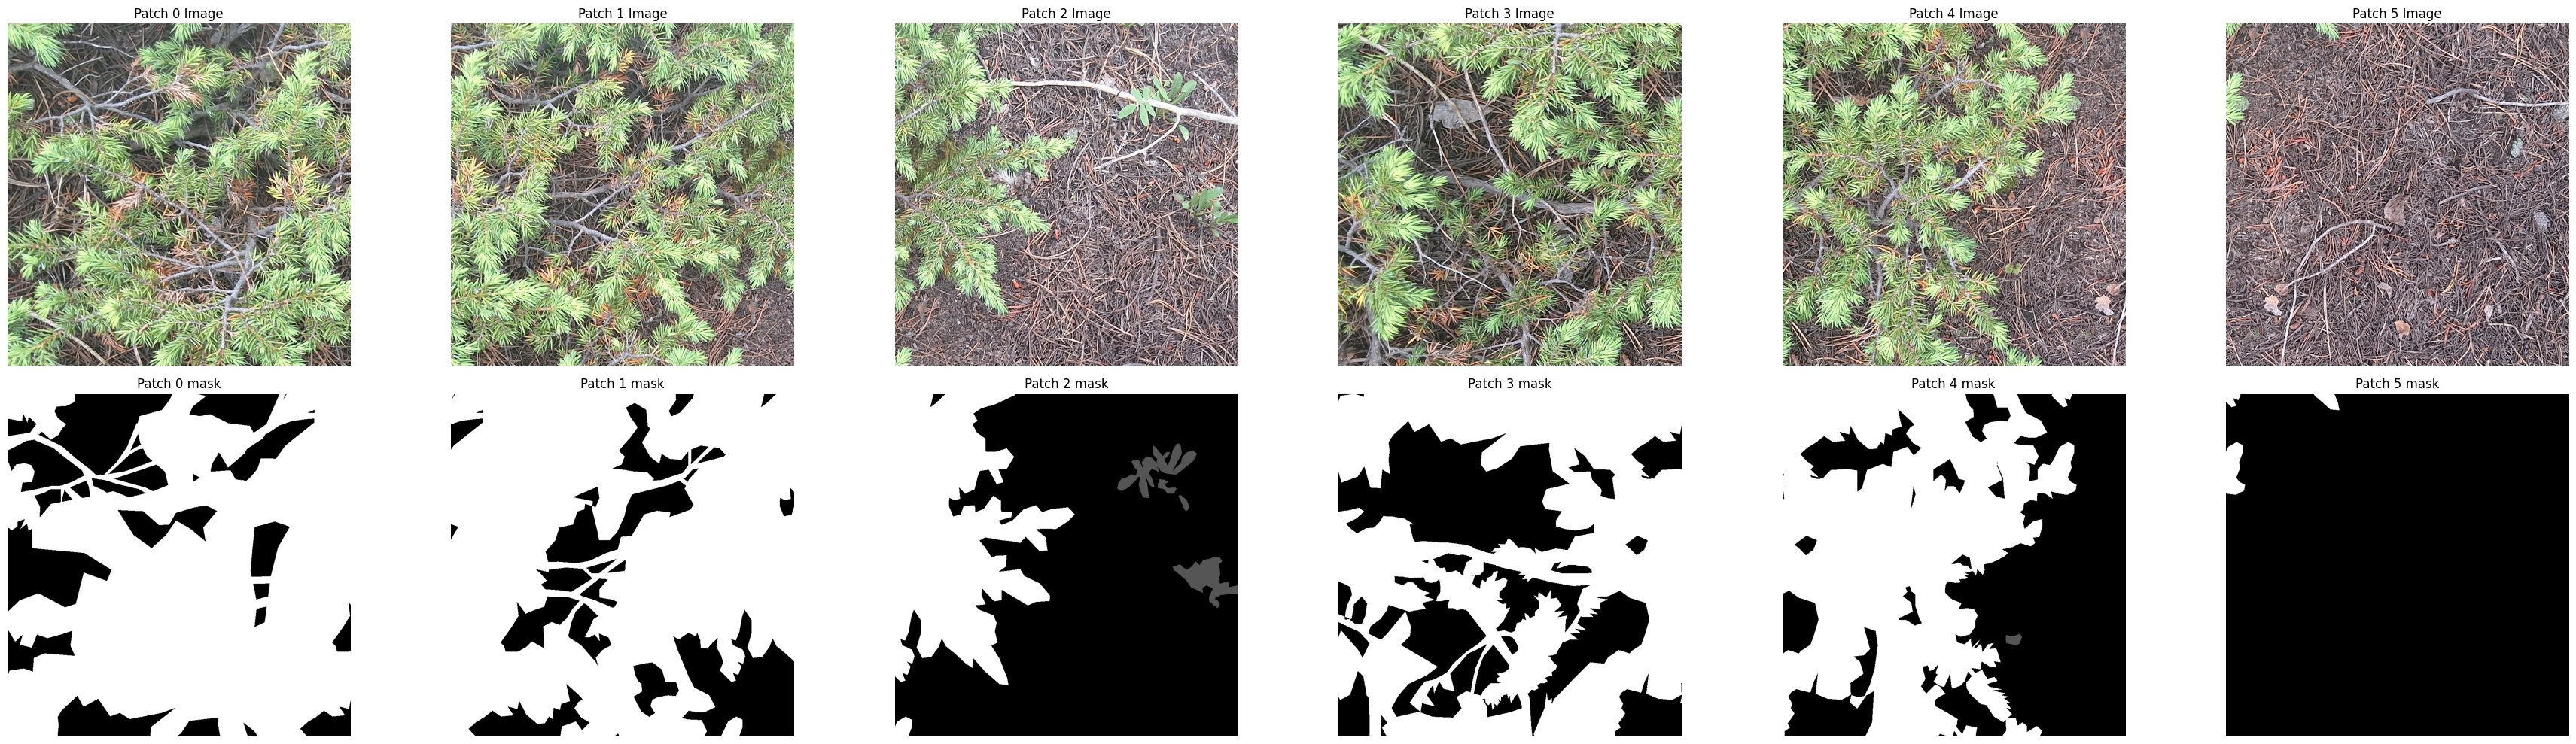

In [4]:
def show_dataset_sample(dataset, idx = 0):
    patch_tuples = dataset[idx]
    num_patches = len(patch_tuples)

    fig, axes = plt.subplots(2, num_patches, figsize=(6*num_patches, 10))
    for i, (img_patch, mask_tensor) in enumerate(patch_tuples):
        if isinstance(img_patch, torch.Tensor):
            img_patch = img_patch.permute(1,2,0).cpu().numpy()
        axes[0,i].imshow(img_patch)
        axes[0,i].set_title(f'Patch {i} Image')
        axes[0,i].axis('off')

        if isinstance(mask_tensor, torch.Tensor):
            mask_np = mask_tensor.cpu().numpy()
        else:
            mask_np = mask_tensor
        axes[1,i].imshow(mask_np, cmap='gray')
        axes[1,i].set_title(f'Patch {i} mask')
        axes[1,i].axis('off')
    plt.tight_layout()
    plt.show()

dir = "/home/nels/TeamVida/Tick Dataset"
#Image_path = "TestImage.jpg"
#Mask_path = "TestImageMask.png"
dataset = VegetationDataset(root_dir=dir, tranform=None)
show_dataset_sample(dataset, idx=2)

In [8]:
def pixel_accuracy(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        valid = (target >= 0)
        correct = (pred == target) * valid
        acc = correct.sum().float() / valid.sum().float()
    return acc.item()


In [21]:
def intersection_and_union(output, target, num_classes, eps=1e-6):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1).view(-1)
        target = target.view(-1)
        intersection = torch.zeros(num_classes).to(output.device)
        union = torch.zeros(num_classes).to(output.device)
        for cls in range(num_classes):
            pred_inds = (pred == cls)
            target_inds = (target == cls)
            inter = (pred_inds & target_inds).sum().float()
            uni = (pred_inds | target_inds).sum().float()
            intersection[cls] = inter
            union[cls] = uni
        iou = (intersection + eps) / (union + eps)
    return intersection, union, iou

In [25]:
def train_unet(model, dataloader, optimizer, criterion, device, num_classes=4):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total_pixels = 0
    total_intersection = torch.zeros(num_classes).to(device)
    total_union = torch.zeros(num_classes).to(device)

    for batch in tqdm(dataloader, desc="Training"):
        sample = batch[0]  # Unwrap since batch_size = 1

        all_img_patches = []
        all_mask_patches = []

        for img_patch, mask_patch in sample:
            if not isinstance(img_patch, torch.Tensor):
                img_patch = transforms.ToTensor()(img_patch)
            if not isinstance(mask_patch, torch.Tensor):
                mask_patch = torch.from_numpy(mask_patch)
            all_img_patches.append(img_patch)
            all_mask_patches.append(mask_patch)

        images = torch.stack(all_img_patches).to(device)           # [N, C, H, W]
        masks = torch.stack(all_mask_patches).to(device).long()    # [N, H, W]

        optimizer.zero_grad()
        outputs = model(images)                                    # [N, C, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = torch.argmax(outputs, dim=1)                       # [N, H, W]
        correct = (preds == masks).sum().item()
        total = masks.numel()
        running_acc += correct
        total_pixels += total

        # IoU accumulation
        intersection, union, _ = intersection_and_union(outputs, masks, num_classes)
        total_intersection += intersection
        total_union += union

    avg_loss = running_loss / total_pixels * masks.shape[1] * masks.shape[2]
    avg_acc = running_acc / total_pixels * 100

    iou_per_class = (total_intersection / (total_union + 1e-6)).cpu().numpy()
    mean_iou = iou_per_class.mean()

    return avg_loss, avg_acc, mean_iou, iou_per_class

In [26]:
def validate_unet(model, dataloader, criterion, device, num_classes=4):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    total_pixels = 0
    total_intersection = torch.zeros(num_classes).to(device)
    total_union = torch.zeros(num_classes).to(device)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            sample = batch[0]  # unwrap since batch_size = 1

            images_list = []
            masks_list = []

            for img_patch, mask_patch in sample:
                if not isinstance(img_patch, torch.Tensor):
                    img_patch = transforms.ToTensor()(img_patch)
                if not isinstance(mask_patch, torch.Tensor):
                    mask_patch = torch.from_numpy(mask_patch)
                images_list.append(img_patch)
                masks_list.append(mask_patch)

            images = torch.stack(images_list).to(device)             # [N, C, H, W]
            masks = torch.stack(masks_list).to(device).long()        # [N, H, W]

            outputs = model(images)                                  # [N, C, H, W]
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)                     # [N, H, W]
            correct = (preds == masks).sum().item()
            total = masks.numel()
            running_acc += correct
            total_pixels += total

             # IoU accumulation
            intersection, union, _ = intersection_and_union(outputs, masks, num_classes)
            total_intersection += intersection
            total_union += union

    avg_loss = running_loss / len(dataloader.dataset)               # loss per image
    avg_acc = running_acc / total_pixels * 100                      # pixel acc %
    iou_per_class = (total_intersection / (total_union + 1e-6)).cpu().numpy()
    mean_iou = iou_per_class.mean()
    return avg_loss, avg_acc, mean_iou, iou_per_class

In [15]:
from torch.utils.data import random_split

def create_train_val_datasets(full_dataset, val_ratio=0.2, seed=42):
    dataset_len = len(full_dataset)
    val_len = int(dataset_len * val_ratio)
    train_len = dataset_len - val_len
    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len], generator=generator)
    return train_dataset, val_dataset

full_dataset = VegetationDataset(root_dir="/home/nels/TeamVida/Tick Dataset", patch_size=512, overlap=100, tranform=None)
train_dataset, val_dataset = create_train_val_datasets(full_dataset, val_ratio=0.2)

In [16]:
import numpy as np
import torch
from collections import defaultdict

def compute_class_frequencies(dataset, num_classes):
    pixel_counts = np.zeros(num_classes, dtype=np.int64)

    for i in range(len(dataset)):
        sample = dataset[i]  # sample is a list of (image_patch, mask_patch)
        for _, mask in sample:
            if isinstance(mask, torch.Tensor):
                mask_np = mask.cpu().numpy()
            else:
                mask_np = np.array(mask)

            for cls in range(num_classes):
                pixel_counts[cls] += np.sum(mask_np == cls)

    total_pixels = np.sum(pixel_counts)
    frequencies = pixel_counts / total_pixels
    return pixel_counts, frequencies


num_classes = 4
pixel_counts, class_freqs = compute_class_frequencies(train_dataset, num_classes)

print("Pixel Counts:", pixel_counts)
print("Class Frequencies:", class_freqs)

Pixel Counts: [396458354  49977765  57554014  37337227]
Class Frequencies: [0.73238189 0.09232448 0.10632016 0.06897347]


Smooth freqs to avoid massive boost

In [19]:
weights = torch.tensor(np.log(1.0 / class_freqs + 1), dtype=torch.float32)
print(weights)

tensor([0.8610, 2.4708, 2.3423, 2.7407])


In [20]:
import segmentation_models_pytorch as smp

unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=4
)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU")
unet_model = unet_model.to(device)
criterion = nn.CrossEntropyLoss(weight=weights.to(device)) 
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)

# Create DataLoaders 
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: x)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc, train_miou, train_iou_per_class = train_unet(unet_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_miou, val_iou_per_class = validate_unet(unet_model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train => Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, mIoU: {train_miou:.4f}")
    print(f"  Val   => Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, mIoU: {val_miou:.4f}")

GPU


Training:   0%|          | 0/59 [00:00<?, ?it/s]

Validating: 100%|██████████| 14/14 [04:18<00:00, 18.45s/it]


Epoch 1/10
  Train => Loss: 1.3080, Acc: 44.42%, mIoU: 0.1827
  Val   => Loss: 30.6677, Acc: 77.91%, mIoU: 0.3387


Validating: 100%|██████████| 14/14 [04:18<00:00, 18.49s/it]


Epoch 2/10
  Train => Loss: 1.1113, Acc: 62.29%, mIoU: 0.2691
  Val   => Loss: 27.0106, Acc: 80.55%, mIoU: 0.3512


Validating: 100%|██████████| 14/14 [04:17<00:00, 18.41s/it]


Epoch 3/10
  Train => Loss: 1.0344, Acc: 66.23%, mIoU: 0.2983
  Val   => Loss: 21.8900, Acc: 83.64%, mIoU: 0.3711


Validating: 100%|██████████| 14/14 [04:21<00:00, 18.69s/it]


Epoch 4/10
  Train => Loss: 0.9622, Acc: 69.52%, mIoU: 0.3395
  Val   => Loss: 20.6648, Acc: 83.79%, mIoU: 0.4404


Validating: 100%|██████████| 14/14 [04:16<00:00, 18.35s/it]


Epoch 5/10
  Train => Loss: 0.8983, Acc: 72.51%, mIoU: 0.3799
  Val   => Loss: 20.5104, Acc: 84.78%, mIoU: 0.4380


Validating: 100%|██████████| 14/14 [04:19<00:00, 18.55s/it]


Epoch 6/10
  Train => Loss: 0.8315, Acc: 74.65%, mIoU: 0.4175
  Val   => Loss: 22.1027, Acc: 82.90%, mIoU: 0.4050


Validating: 100%|██████████| 14/14 [04:21<00:00, 18.65s/it]


Epoch 7/10
  Train => Loss: 0.7888, Acc: 76.59%, mIoU: 0.4508
  Val   => Loss: 21.1734, Acc: 84.78%, mIoU: 0.4574


Validating: 100%|██████████| 14/14 [04:18<00:00, 18.48s/it]


Epoch 8/10
  Train => Loss: 0.7699, Acc: 77.14%, mIoU: 0.4600
  Val   => Loss: 18.6415, Acc: 85.84%, mIoU: 0.4959


Validating: 100%|██████████| 14/14 [04:20<00:00, 18.63s/it]


Epoch 9/10
  Train => Loss: 0.6849, Acc: 80.52%, mIoU: 0.5283
  Val   => Loss: 20.2576, Acc: 83.87%, mIoU: 0.4194


Validating: 100%|██████████| 14/14 [04:18<00:00, 18.50s/it]

Epoch 10/10
  Train => Loss: 0.6148, Acc: 83.75%, mIoU: 0.5899
  Val   => Loss: 18.3947, Acc: 88.90%, mIoU: 0.5304


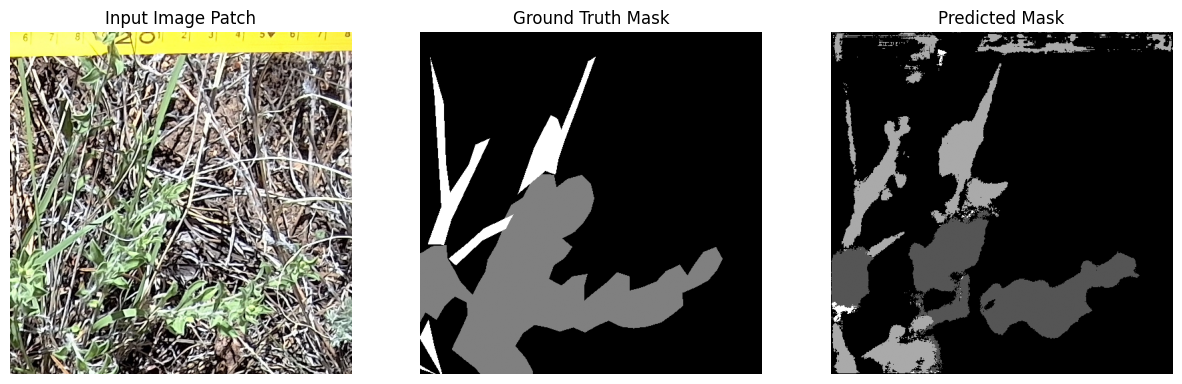

In [28]:
# Select a sample from your validation dataset (or a sample patch)
sample = val_dataset[8]  # get the first sample (a list of patches)
# Choose one patch, for instance, the first patch in the sample
img_patch, mask_patch = sample[5]

# Convert to tensor if needed and add batch dimension
if not isinstance(img_patch, torch.Tensor):
    img_patch = transforms.ToTensor()(img_patch)
img_patch = img_patch.unsqueeze(0).to(device)

# Run the model forward pass
unet_model.eval()
with torch.no_grad():
    output = unet_model(img_patch)  # assume UNet returns logits

# Get predicted class for every pixel
pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# Visualize input, ground truth, and predicted mask
# Convert image patch to numpy for display (if normalized, you may need to un-normalize)
img_np = img_patch.squeeze(0).cpu().permute(1,2,0).numpy()
mask_np = mask_patch.cpu().numpy()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title("Input Image Patch")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask_np, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

/tmp/ipykernel_987/3788399520.py:52: RuntimeWarning: invalid value encountered in divide
  full_image /= image_count
/tmp/ipykernel_987/3788399520.py:53: RuntimeWarning: invalid value encountered in divide
  full_mask /= mask_count
/tmp/ipykernel_987/3788399520.py:54: RuntimeWarning: invalid value encountered in divide
  pred_mask /= pred_count
/tmp/ipykernel_987/3788399520.py:57: RuntimeWarning: invalid value encountered in cast
  full_mask = full_mask.round().astype(np.uint8)
/tmp/ipykernel_987/3788399520.py:58: RuntimeWarning: invalid value encountered in cast
  pred_mask = pred_mask.round().astype(np.uint8)


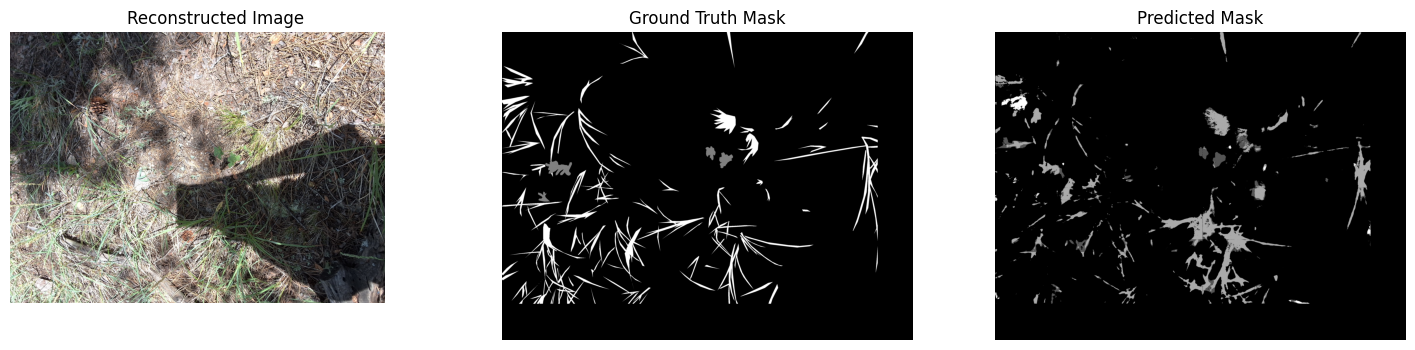

In [41]:
patch_size = 512
overlap = 100
stride = patch_size - overlap
full_h, full_w = 2448, 3264  # Full image size

# Get patch list from dataset
sample = val_dataset[0]  # sample = list of (img_patch, mask_patch) pairs

# Initialize containers
full_image = np.zeros((full_h, full_w, 3), dtype=np.float32)
full_mask = np.zeros((full_h, full_w), dtype=np.float32)
pred_mask = np.zeros((full_h, full_w), dtype=np.float32)

# Overlap counter for averaging
image_count = np.zeros((full_h, full_w, 1), dtype=np.float32)
mask_count = np.zeros((full_h, full_w), dtype=np.float32)
pred_count = np.zeros((full_h, full_w), dtype=np.float32)

# Loop over patches
patch_idx = 0
for y in range(0, full_h - patch_size + 1, stride):
    for x in range(0, full_w - patch_size + 1, stride):
        img_patch, mask_patch = sample[patch_idx]
        
        if not isinstance(img_patch, torch.Tensor):
            img_patch_tensor = transforms.ToTensor()(img_patch)
        else:
            img_patch_tensor = img_patch

        img_patch_tensor = img_patch_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = unet_model(img_patch_tensor)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Convert image patch to numpy
        img_np = img_patch_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        mask_np = mask_patch.cpu().numpy()

        # Add to full image/mask
        full_image[y:y+patch_size, x:x+patch_size] += img_np
        full_mask[y:y+patch_size, x:x+patch_size] += mask_np
        pred_mask[y:y+patch_size, x:x+patch_size] += pred

        image_count[y:y+patch_size, x:x+patch_size] += 1
        mask_count[y:y+patch_size, x:x+patch_size] += 1
        pred_count[y:y+patch_size, x:x+patch_size] += 1

        patch_idx += 1

# Average overlapping areas
full_image /= image_count
full_mask /= mask_count
pred_mask /= pred_count

# Round masks to nearest class integer
full_mask = full_mask.round().astype(np.uint8)
pred_mask = pred_mask.round().astype(np.uint8)

# --- Visualization ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(full_image)
plt.title("Reconstructed Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(full_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

Image 20 is good (train)

Image 3 (Val)

In [42]:
torch.save(unet_model.state_dict(), 'unet_model_2.pth')